In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
def loadAllData(path):
    """
    Load all the volatility for all day in a numpy array
    Use for the PCA
    """
    #loading data (pickle file)
    unpickled_df = pd.read_pickle(path)
    Ndays = len(unpickled_df)
    data = np.empty((Ndays,441))
    j = 0
    maturities = [5,13,36,58,80,110,140,200,300,400,500,800,900,1150,1400,1550,2000,2450,2700,2900,3200]
    myrow = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

    for df in unpickled_df:
        
        df.set_index(['nBizDays'], inplace = True)
            
        
        #Add rows in df for maturity that we want
        for i in maturities:
            exitingIndex = i in df.index
            if exitingIndex == False :
                
                df.loc[i] = myrow
        df.sort_index(inplace = True)

        #interpolation
        for col in df:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df.interpolate(method = "values", limit_direction = "both", inplace = True)
        
        #Fill allData in 1 np.array
        df.drop(columns=['Forwards', 'nCalDays', 'diff Days'], inplace = True)
        df = df.loc[maturities,:]
        Nrows = len(df)
        Ncolumns = len(df.columns)
        data[j] = np.array(df.iloc[:,:], dtype = np.float).reshape(-1)
        j = j + 1
    return data

In [ ]:
data = loadAllData("/content/NKY_clean.pkl")

We normalize the data between 0 and 1:

In [ ]:
from sklearn import preprocessing
n_train = int(len(data)*100/100)
trainData = data[:n_train]
testData = data[n_train:]
mms = preprocessing.MinMaxScaler()
trainDataScaled = mms.fit_transform(trainData)

Now we can start building a simple autoencoder. We will use Keras. We build an autoencoder with a single hidden layer containing 40 neurons, and an input and output layer of size 441. We use ReLU as activation function in the hidden layer and Sigmoid in the output layer


In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
# this is the size of our encoded representations
encoding_dim = 12  # 40 floats -> compression of factor 0.1, assuming the input is 400 floats

# this is our input placeholder
input = Input(shape=(441,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(441, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(inputs=input, outputs=encoded)

In [ ]:
# create a placeholder for an encoded (40-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

We train over 1000
 epochs, with a batch size of 100. Finally, we get the prediction of the network for our data

In [ ]:
model_autoencoder = autoencoder.fit(trainDataScaled, trainDataScaled,
                epochs=500,
                batch_size=100,
                shuffle=True,
                validation_split = 0.1,
                verbose=0)

ValueError: ignored

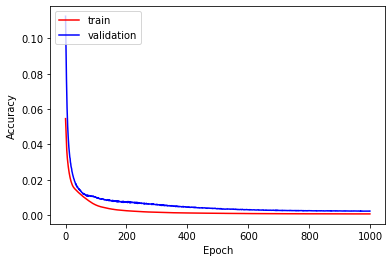

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_autoencoder.history["loss"], color = "r")
plt.plot(model_autoencoder.history["val_loss"], color = "b")
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 441)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                5304      
_________________________________________________________________
dense_3 (Dense)              (None, 441)               5733      
Total params: 11,037
Trainable params: 11,037
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded = encoder.predict(trainDataScaled)
decoded = decoder.predict(encoded)
print(trainDataScaled[10][10:30])
print(decoded[10,10:30])

[0.37622958 0.3816288  0.39162443 0.41421101 0.36725041 0.27162199
 0.20068412 0.15833117 0.14027665 0.12678284 0.1234475  0.44597181
 0.43000019 0.40881552 0.37534273 0.37200665 0.44898947 0.35448376
 0.34521344 0.34234831]
[0.3984453  0.39915776 0.3983334  0.41135657 0.36819178 0.28509498
 0.21433836 0.17269185 0.15583506 0.14364058 0.1402379  0.43799615
 0.4280656  0.41246057 0.37912482 0.36777705 0.4370076  0.36148053
 0.36793804 0.3650827 ]


We compute the euclidean distance from each point to its reconstruction. We use it as an outlier score:

Text(0.5, 1.0, 'Outlier Score for each observations')

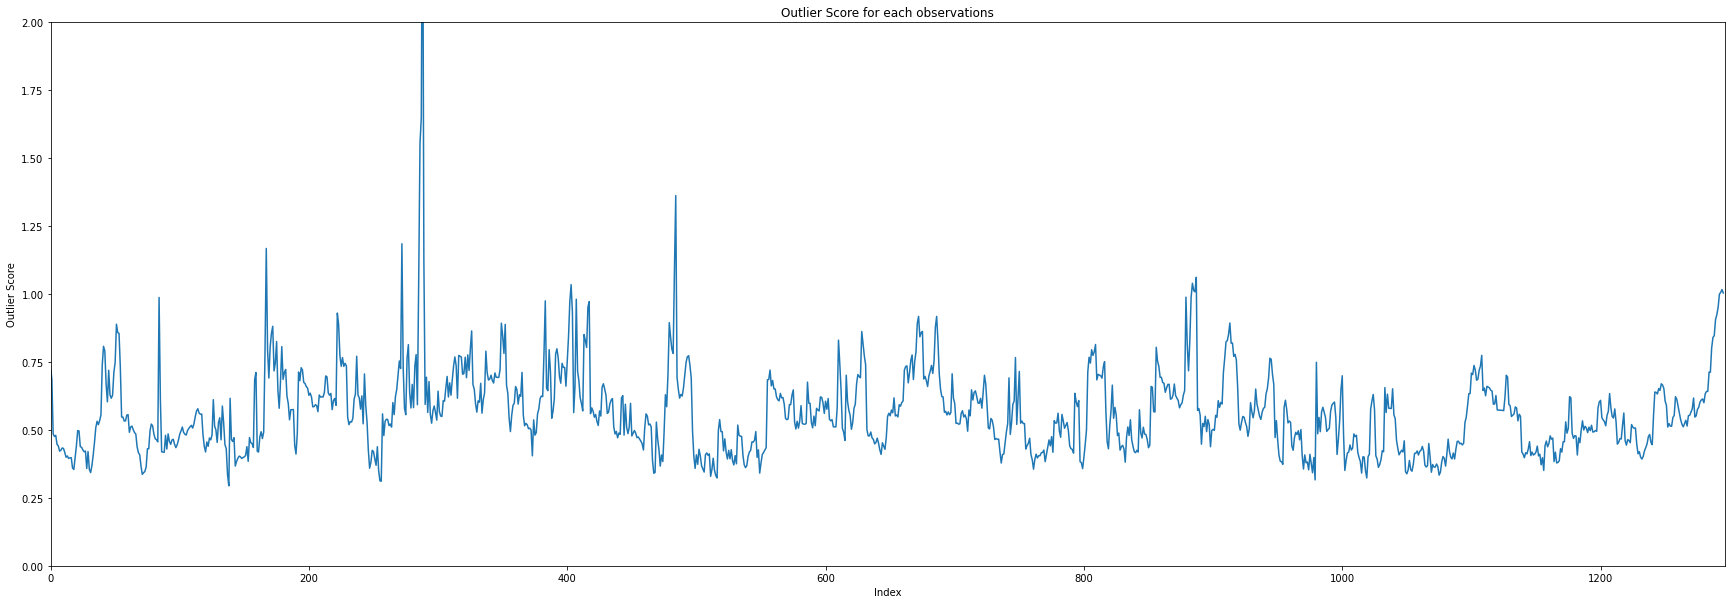

In [ ]:
dist = np.zeros(len(trainDataScaled))
for i, x in enumerate(trainDataScaled):
    dist[i] = np.linalg.norm(x-decoded[i])
plt.figure(figsize=(30,10))
plt.plot(dist)
plt.xlim((0,1296))
plt.ylim((0,2))
plt.xlabel('Index')
plt.ylabel('Outlier Score')
plt.title("Outlier Score for each observations")

Text(0.5, 1.0, 'Reconstruction error in each dimension of point 287')

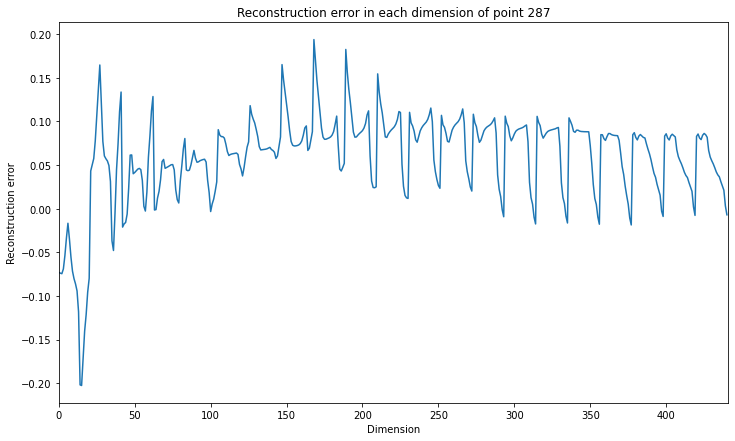

In [ ]:
def compute_error_per_dim(point):
    p = trainDataScaled[point,:].reshape(1,441)
    encoded = encoder.predict(p)
    decoded = decoder.predict(encoded)
    return np.array(p - decoded)[0]
plt.figure(figsize=(12,7))
plt.plot(compute_error_per_dim(287))
plt.xlim((0,441))
plt.xlabel('Dimension')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point 287")

In [ ]:
outliers = [i for (i, x) in enumerate(dist) if x > 0.8]
print(outliers)

[41, 51, 52, 53, 84, 167, 170, 171, 172, 175, 179, 222, 223, 272, 277, 285, 286, 287, 288, 289, 326, 349, 350, 352, 383, 401, 402, 403, 404, 407, 413, 414, 415, 416, 417, 479, 480, 483, 484, 610, 628, 629, 671, 672, 673, 674, 675, 685, 686, 687, 809, 856, 879, 880, 882, 883, 884, 885, 886, 887, 910, 911, 912, 913, 914, 915, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295]
